# 住宅販売価格を予測する
早川　裕樹

In [3]:
%matplotlib inline 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

In [4]:
df_data = pd.read_csv("./data/kc_house_data.csv")
df_data["price"] = df_data["price"] / 10**6 #単位を100万ドルにしておく

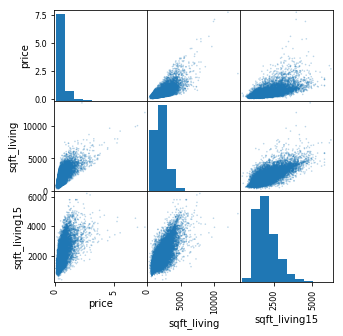

In [5]:
# 1.目的変数と説明変数の関係を確認するためのグラフを作成する。
y_var = ["price"]
X_var = ["sqft_living","sqft_living15"]
df = df_data[y_var+ X_var]
pd.plotting.scatter_matrix(df,alpha=0.3, s=10, figsize=(5,5))
plt.show()

不適切な項目除去
（lat,longはｴﾘｱごとに区切ることで使えそう）

In [6]:
df_data_tmp1 = df_data.drop("id",axis=1).drop("date",axis=1).drop("lat",axis=1).drop("long",axis=1).drop("zipcode",axis=1)

標準化

In [7]:
scaler = StandardScaler()
std = pd.DataFrame(scaler.fit_transform(df_data_tmp1), columns=df_data_tmp1.columns)
std_tmp = pd.concat([df_data_tmp1["price"], std.drop(["price"], axis=1)], axis=1)

偏相関係数確認

In [8]:
df = std_tmp.drop(["price"], axis=1)
for cname in df.columns:  
    y=df[cname]
    X=df.drop(cname, axis=1)
    regr = LinearRegression(fit_intercept=True)
    regr.fit(X, y)
    rsquared = regr.score(X,y)
    print(cname,":" ,1/(1-np.power(rsquared,2)))

bedrooms : 1.18130683955
bathrooms : 1.96782790577
sqft_living : inf
sqft_lot : 1.37276984529
floors : 1.30326907846
waterfront : 1.02933168809
view : 1.09036491964
condition : 1.03403803652
grade : 1.91300570154
sqft_above : inf
sqft_basement : inf
yr_built : 1.3387225405
yr_renovated : 1.01604977096
sqft_living15 : 1.7129254385
sqft_lot15 : 1.38647086691


C:\Users\yuuki.hayakawa.ULDOMAIN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  


infとなっている項目をsqft_living以外除外

In [9]:
std_tmp1 = std_tmp.drop(["sqft_above", "sqft_basement"], axis=1)

In [12]:
import statsmodels.api as sm

count = 1
for i in range(7): # 重いので1に変更（実際には7で実施）
    combi = itertools.combinations(std_tmp1.drop("price",axis=1).columns, i+1 ,) #組み合わせを求める
    for v in combi:
        y = std_tmp1["price"]
        X = sm.add_constant(std_tmp1[list(v)])
        model = sm.OLS(y, X).fit()
        if count == 1:
            min_aic = model.aic
            min_var = list(v)
        if min_aic > model.aic:
            min_aic = model.aic
            min_var = list(v)
        count += 1
        # print("AIC:",round(model.aic), "変数:",list(v))
print("====minimam AIC====")
print(min_var,min_aic)

====minimam AIC====
['bedrooms', 'bathrooms', 'sqft_living', 'waterfront', 'view', 'grade', 'yr_built'] -4643.93859289


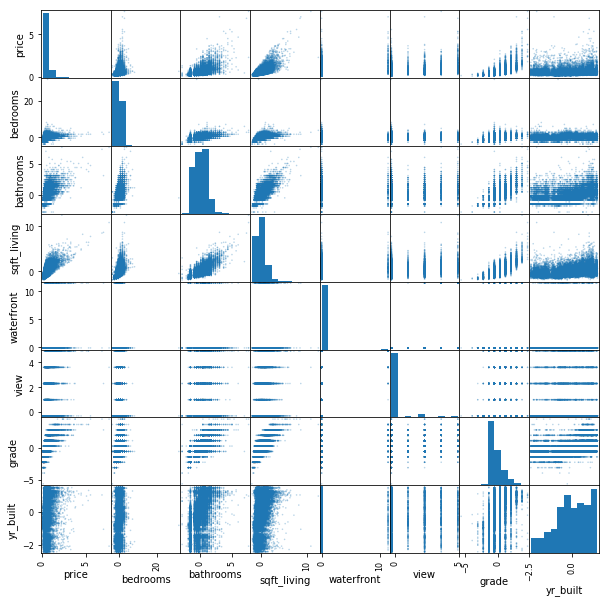

In [13]:
# AICがもっとも低かったパラメータのグラフ描画
df_data_aic = std_tmp1[["price", 'bedrooms', 'bathrooms', 'sqft_living', 'waterfront', 'view', 'grade', 'yr_built']]
pd.plotting.scatter_matrix(df_data_aic,alpha=0.3, s=10, figsize=(10,10))
plt.show()

交差検証

In [ ]:
y = std_tmp1["price"].values
X = std_tmp1[['bedrooms', 'bathrooms', 'sqft_living', 'waterfront', 'view', 'grade', 'yr_built']].values

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

kf = KFold(n_splits=5, random_state=1234, shuffle=True)
kf.get_n_splits(X, y)

df_result = pd.DataFrame()

for train_index, test_index in kf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    regr = LinearRegression(fit_intercept=True)
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)
    df = pd.DataFrame({"y_test":y_test, "y_pred":y_pred})
    df_result = pd.concat([df_result, df], axis=0)

# 評価指標の算出
y_test = df_result["y_test"]
y_pred = df_result["y_pred"]
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("MSE=%s"%round(mse,3) )
print("RMSE=%s"%round(np.sqrt(mse), 3) )
print("MAE=%s"%round(mae,3) )


TRAIN: [    0     1     2 ..., 21609 21610 21612] TEST: [    4    13    14 ..., 21603 21605 21611]
TRAIN: [    0     1     2 ..., 21610 21611 21612] TEST: [    5     6     8 ..., 21599 21600 21607]
TRAIN: [    3     4     5 ..., 21609 21611 21612] TEST: [    0     1     2 ..., 21595 21606 21610]
TRAIN: [    0     1     2 ..., 21610 21611 21612] TEST: [   11    28    39 ..., 21597 21601 21604]
TRAIN: [    0     1     2 ..., 21607 21610 21611] TEST: [    3    10    15 ..., 21608 21609 21612]
MSE=0.047
RMSE=0.217
MAE=0.141


In [ ]:
kf = KFold(n_splits=5, random_state=1234, shuffle=True)
kf.get_n_splits(X, y)

df_result = pd.DataFrame()

for train_index, test_index in kf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
    svr_rbf.fit(X_train, y_train)
    y_pred = svr_rbf.predict(X_test)
    df = pd.DataFrame({"y_test":y_test, "y_pred":y_pred})
    df_result = pd.concat([df_result, df], axis=0)
    
# 評価指標の算出
y_test = df_result["y_test"]
y_pred = df_result["y_pred"]
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("MSE=%s"%round(mse,3) )
print("RMSE=%s"%round(np.sqrt(mse), 3) )
print("MAE=%s"%round(mae,3) )


TRAIN: [    0     1     2 ..., 21609 21610 21612] TEST: [    4    13    14 ..., 21603 21605 21611]
TRAIN: [    0     1     2 ..., 21610 21611 21612] TEST: [    5     6     8 ..., 21599 21600 21607]
